Serial Bias
===========



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

Python exe
/home/albert/miniforge3/envs/torch/bin/python


## Imports



In [13]:
import sys
sys.path.insert(0, '../')
import numpy as np

import torch
from time import perf_counter

from src.network import Network
from src.plasticity import Plasticity
from src.decode import decode_bump

REPO_ROOT = '/home/albert/sims/NeuroTorch/'

## Helpers



In [14]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Single Trial



In [50]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr', LIVE_FF_UPDATE=1)
rates = model(RET_STP=1).cpu().detach().numpy()

In [51]:
print(model.PHI0.shape)

torch.Size([1, 3])


In [52]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(1, 111, 512) (1, 111, 512)


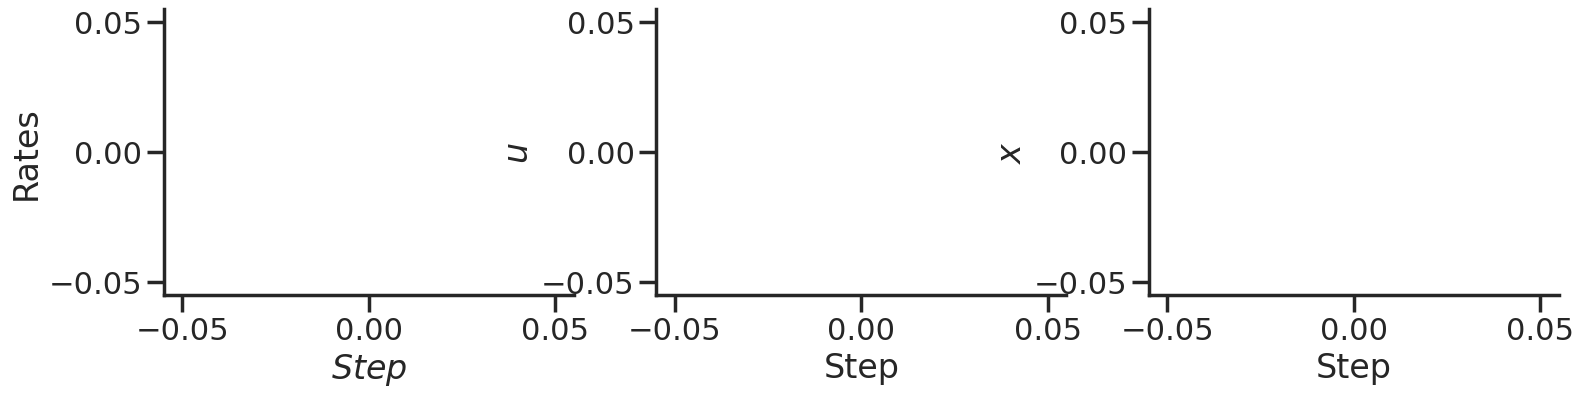

In [53]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])

ax[0].plot(rates.mean(-1).T, 'k')
ax[0].plot(rates[0, :, :10], alpha=.25)
ax[0].set_xlabel('$Step$')
ax[0].set_ylabel('Rates')

ax[1].plot(u_list.mean(-1).T, 'k')
ax[1].plot(u_list[0, :, :10], alpha=.25)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$u$')

ax[2].plot(x_list.mean(-1).T, 'k')
ax[2].plot(x_list[0, :, :10], alpha=.25)
ax[2].set_xlabel('Step')
ax[2].set_ylabel('$x$')

plt.show()

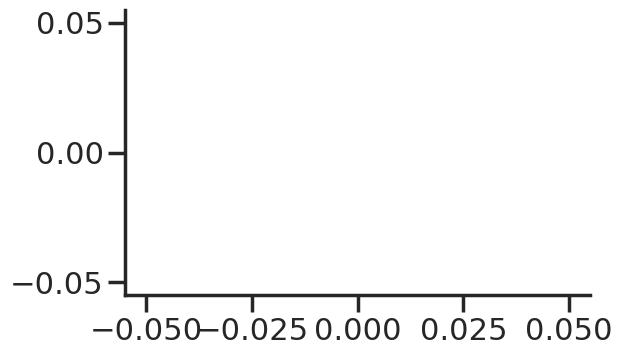

In [54]:
Aux = x_list*u_list
m0, m1, phi = decode_bump(Aux)
plt.plot(m1[0]);

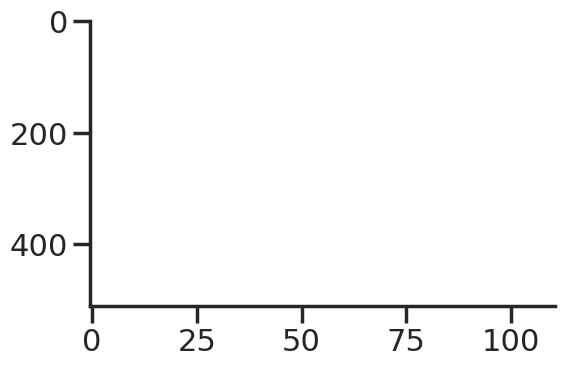

In [55]:
plt.imshow(x_list[0].T*u_list[0].T, aspect='auto')


In [56]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(1, 111)


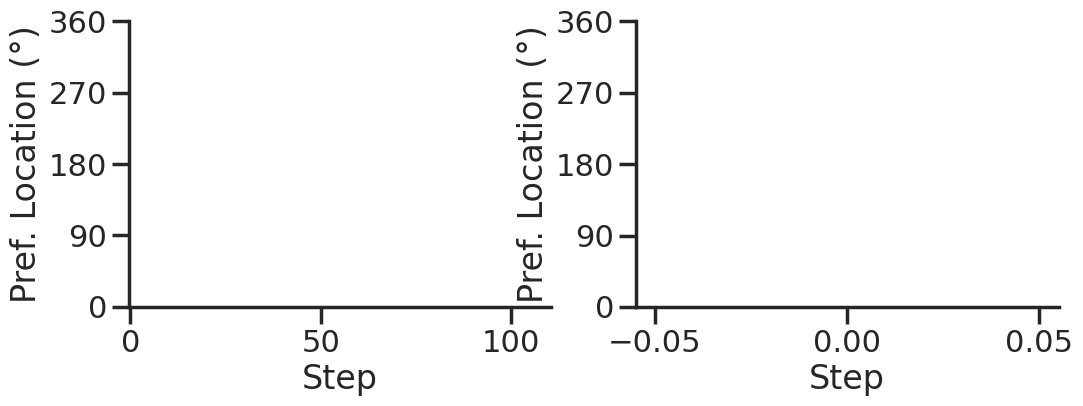

In [57]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=10, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi[0] * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [41]:
rates

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

## Serial Bias



### Batching Live Inputs



In [148]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr', seed=1, LIVE_FF_UPDATE=1)

#########################################################################################################
### WARNING ### YOU NEED TO SET LIVE_FF_UPDATE INSIDE THE MODEL DEF OTHERWISE Ja0 WONT BE SCALED PROPERLY
#########################################################################################################

N_PHASE = 512
print(model.PHI0.shape)

PHI0 = model.PHI0.unsqueeze(-1).repeat((N_PHASE, 1, 1))

print(PHI0.shape)
PHI0[:, -1] = torch.randint(0, 360, (N_PHASE,)).unsqueeze(1)
PHI0[:, 0] = torch.randint(0, 360, (N_PHASE,)).unsqueeze(1)
# print(PHI0[:, :, 0])

torch.Size([1, 3])
torch.Size([512, 3, 1])


In [149]:
model.PHI0 = PHI0
model.N_BATCH = N_PHASE
rates = model(RET_FF=0).cpu().numpy()
print(rates.shape)

(512, 111, 8000)


In [150]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(512, 111)


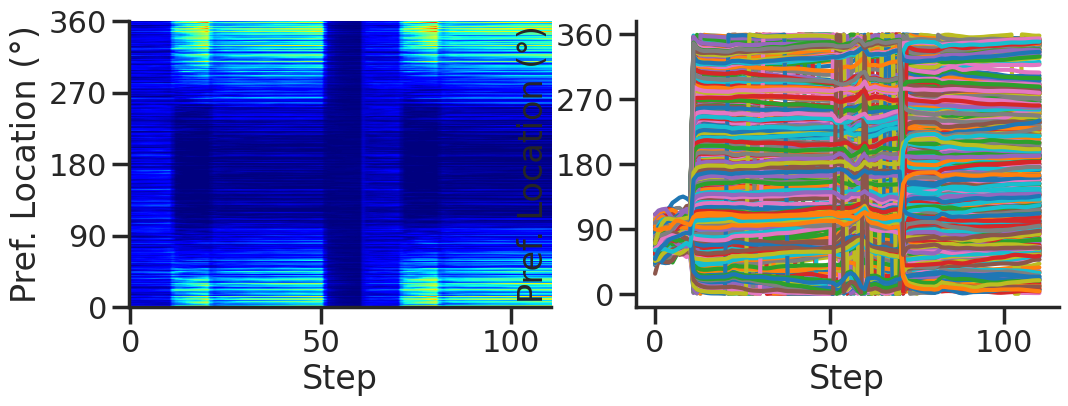

In [151]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=10, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi.T * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [152]:
target_loc = model.PHI0[:, -1].cpu().numpy()
rel_loc = model.PHI0[:, 0].cpu().numpy() - target_loc
rel_loc = (rel_loc/180*np.pi + np.pi) % (2*np.pi) - np.pi
errors = phi - target_loc*np.pi/180.
errors = (errors + np.pi) % (2*np.pi) - np.pi

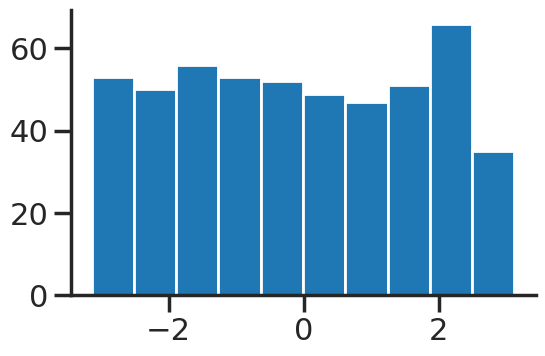

In [153]:
plt.hist(rel_loc);

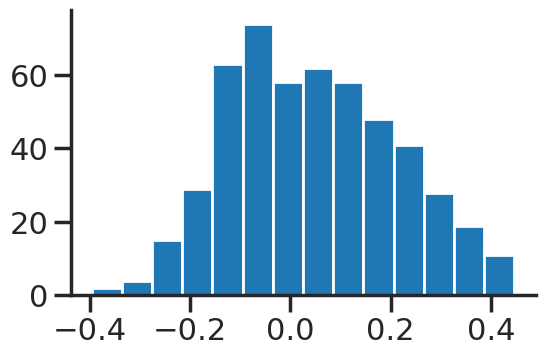

In [154]:
plt.hist(errors[:, -1], bins='auto')
plt.show()

### Systematic biases

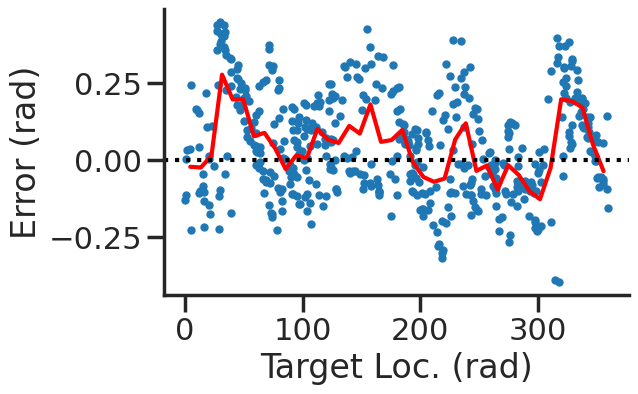

In [155]:
plt.plot(target_loc[:, 0], errors[:,-1], 'o')
plt.xlabel('Target Loc. (rad)')
plt.ylabel('Error (rad)')
#plt.ylim([-60, 60])

from scipy.stats import binned_statistic
stt = binned_statistic(target_loc[:,0], errors[:,-1], statistic='mean', bins=40, range=[0, 360])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")


### Serial biases

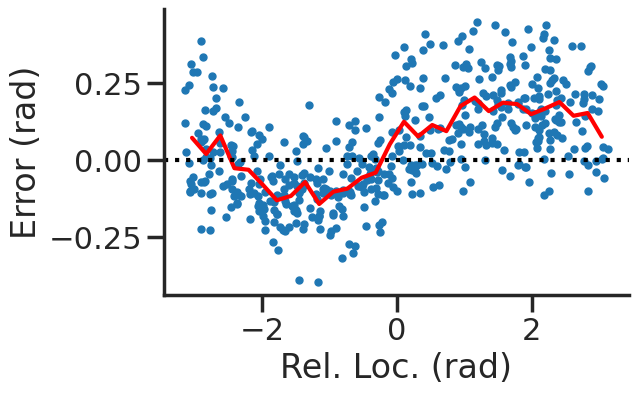

In [156]:
plt.plot(rel_loc[:, 0], errors[:,-1], 'o')
plt.xlabel('Rel. Loc. (rad)')
plt.ylabel('Error (rad)')
#plt.ylim([-60, 60])

from scipy.stats import binned_statistic
stt = binned_statistic(rel_loc[:,0], errors[:,-1], statistic='mean', bins=30, range=[-np.pi, np.pi])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")
plt.show()